In [ ]:
# This is a tutorial to run a simulation using KGBM
# KGBN is a package for simulating the dynamics of gene regulatory networks using inhibitor win rules


In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import KGBM from ./src
import sys
sys.path.append('./src/BNMPy/')
import KGBN 


In [3]:
network = pd.DataFrame({"1":["X","Y","activate"],
                        "2":["X","X","activate"],
                        "3":["X","Z","activate"],
                        "4":["Y","X","activate"],
                        "5":["Y","Y","activate"],
                        "6":["Y","Z","inhibit"],
                        "7":["Z","Z","activate"]
})

network = network.transpose()
network.columns = ["node1","node2","Operation"]

# Analyze the structure of the network
# Load initial network data
#network = pd.read_csv('/Users/guangrong/Documents/GitHub_project/AML digital twin/script/FLT3_NPM1_DNMT3A_model1.csv')
network = pd.read_csv('/Users/guangrong/Documents/GitHub_project/AML digital twin/script/FLT3_NPM1_DNMT3A_add.csv')

#print("starting nodes:")
#print(set(network['node1']) - set(network['node2']))

#print("ending nodes:")
#print(set(network['node2']) - set(network['node1']))

#print("all nodes:")
#print(len(set(network['node1']) | set(network['node2'])))



In [4]:
network

,node1,node2,Operation
0,FLT3,AKT1,activate
1,AKT1,BCL2,activate
2,MAPK1,BCL2,activate
3,NFKB2,BCL2,activate
4,TP53,BCL2,inhibit
5,AKT1,BRAF,activate
6,AKT1,BRAF,inhibit
7,MAPK1,BRAF,inhibit
8,NRAS,BRAF,activate
9,DNMT3A,CCND1,inhibit


[False, False, False, False, True, True, True, False, False, True, False, False, True, True, False, False, True, True, True, False, False, True, True, False]


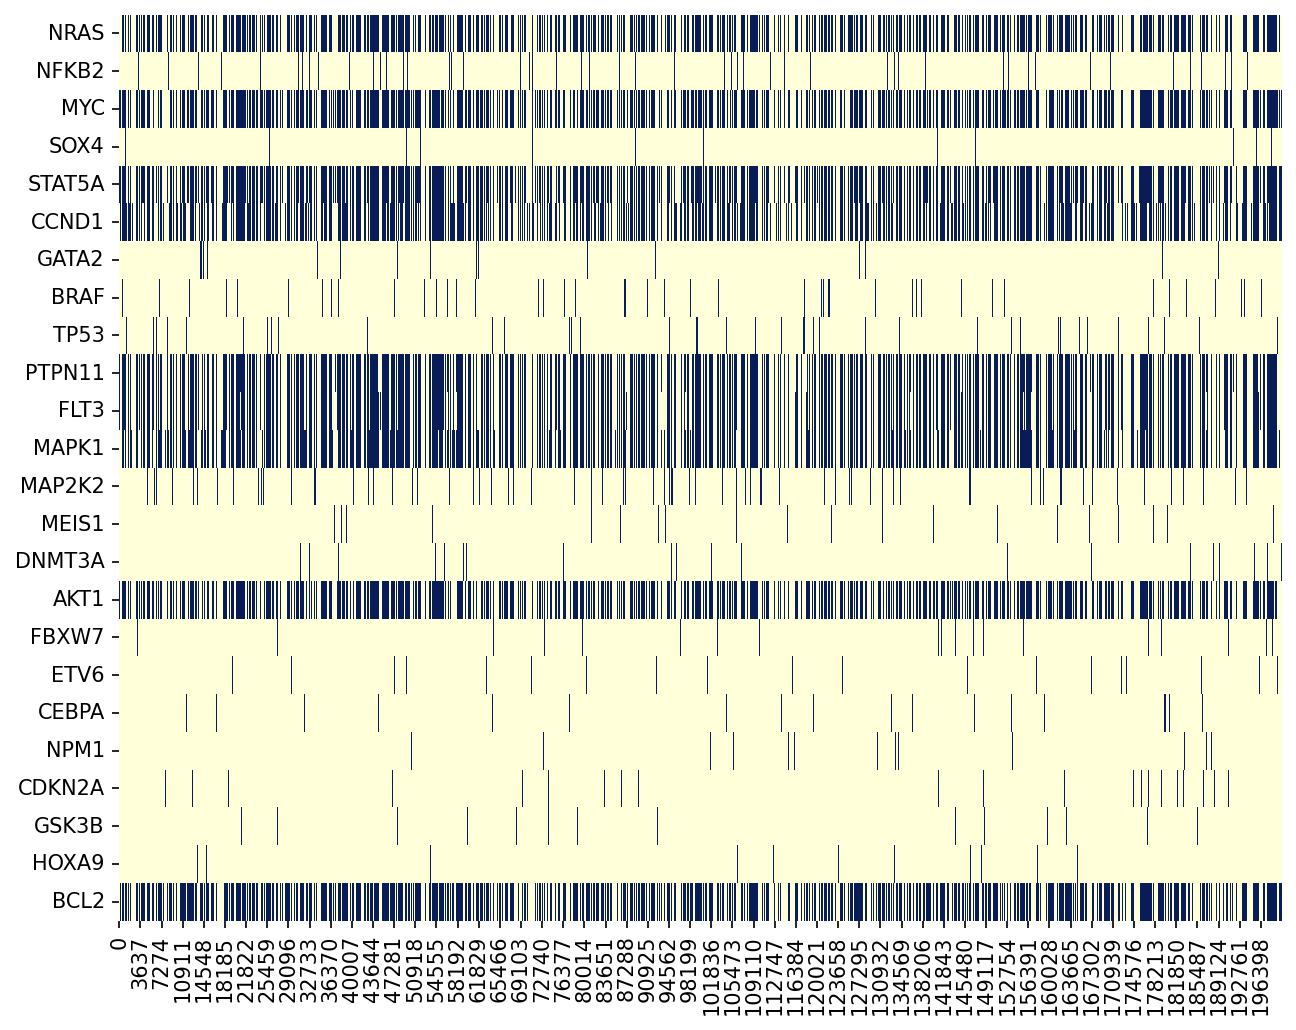

In [167]:
# random initial values
all_nodes = list(set(network['node1']) | set(network['node2']))
initial_values = [random.choice([True,False]) for i in range(0,len(all_nodes))]
print(initial_values)

# model initial
model_initial = KGBN.initial_model(all_nodes=all_nodes, initial_values=initial_values)

# run simulation
dic_nodes_upstream = KGBN.generate_dic_node_upstream(network)
simulations = KGBN.update_models_multisteps(model_initial,dic_nodes_upstream, runs = 200000, fliprop=0.01)

# Convert the simulation results to dataframe so True will became 1 and False will became 0
for node in simulations.keys():
    simulations[node] = [int(x) for x in simulations[node]]
simulations = pd.DataFrame(simulations) 

# plot the simulation results
plt.figure(figsize=(10,len(all_nodes)/3), dpi = 150)
# heapmap without clustering
sns.heatmap(simulations.transpose(),cmap="YlGnBu", cbar = False)
plt.show()


In [168]:


def count_state_frequency(simulations):

    dic_freq = {}
    for i in range(0,simulations.shape[0]):
        cur = simulations.iloc[i,:]
        cur = ','.join([str(x) for x in cur])
        if cur in dic_freq.keys():
            dic_freq[cur] += 1
        else:
            dic_freq[cur] = 1
    result = pd.DataFrame()
    state_list = []
    freq_list = []
    for key in dic_freq.keys():
        state_list.append(key)
        freq_list.append((dic_freq[key]/simulations.shape[0]))
    result['state'] = state_list
    result['freq'] = freq_list
    result.index = state_list
    result = result.drop(columns=['state'])
    return result.sort_values(by=['freq'],ascending=False)



In [169]:
all = pd.DataFrame()
delta = []
pre = count_state_frequency(simulations.iloc[0:10,:])
for i in range(0,14):
    cur = count_state_frequency(simulations.iloc[2**i*10:2**(i+1)*10,:])
    cur.columns = ["S"+str(i)]
    if i > 0:
        delta.append(cur.iloc[0,].values[0] - pre.iloc[0,].values[0])
    pre = cur
    all = pd.concat([all,cur],axis=1)


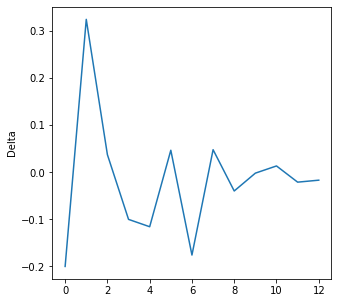

In [170]:
plt.figure(figsize=(5,5))
plt.ylabel("Delta")
plt.plot(delta)

<AxesSubplot:>

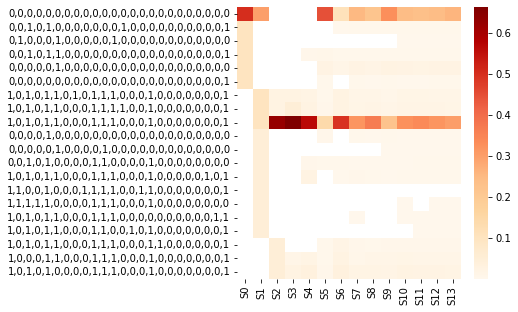

In [171]:
all.head(20)
plt.figure(figsize=(5,5))
sns.heatmap(all.head(20),cmap="OrRd", cbar = True)

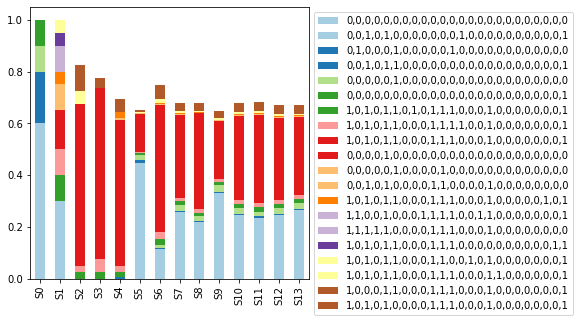

In [172]:
import pandas as pd

#static bar plot
all.head(20).transpose().plot(kind='bar', stacked=True, figsize=(5,5), legend=False, cmap='Paired')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()



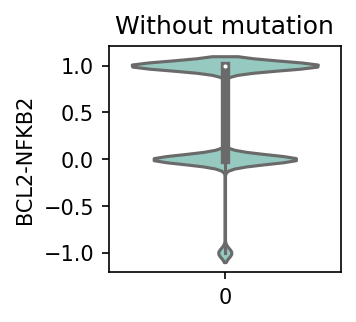

In [174]:
#boxplot
plt.figure(figsize=(2,2), dpi = 150)
# heapmap without clustering
# violinplot
sns.violinplot(data=(simulations['BCL2']-simulations['NFKB2']).values,palette="Set3")  
plt.title("Without mutation")
plt.ylabel("BCL2-NFKB2")
#sns.boxplot(data=simulations['BCL2']-simulations['NFKB2'],palette="Set3")
plt.show()

[True, False, True, True, True, True, True, True, False, True, True, False, False, True, True, True, True, True, False, False, True, True, False, True]
NRAS


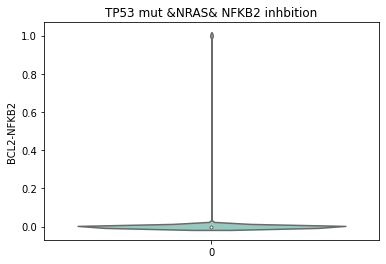

NFKB2


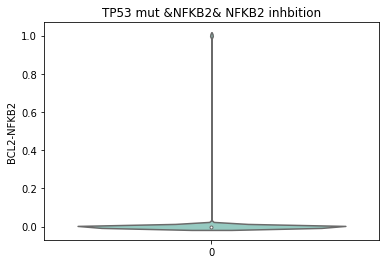

MYC


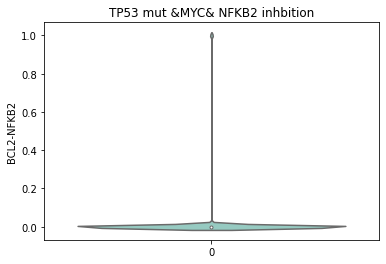

SOX4


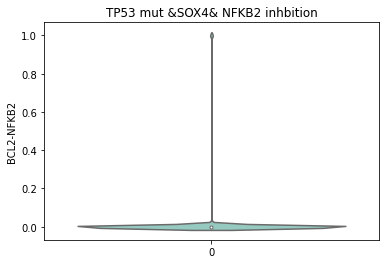

STAT5A


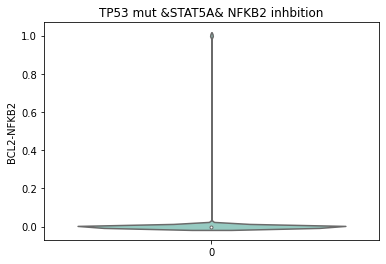

CCND1


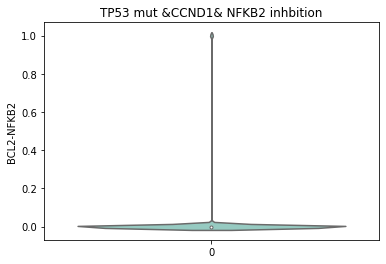

GATA2


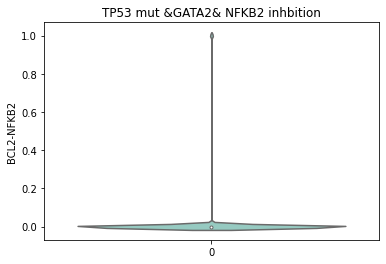

BRAF


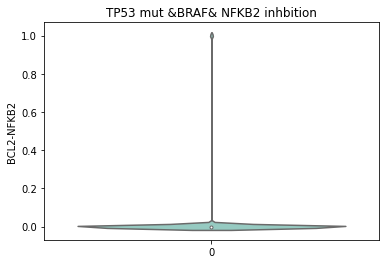

TP53


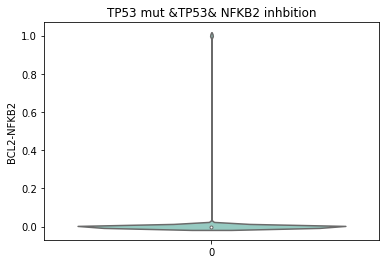

PTPN11


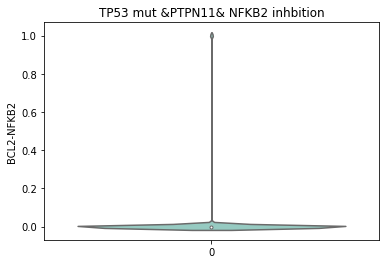

FLT3


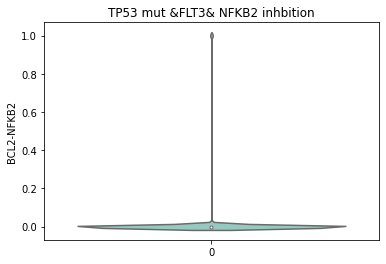

MAPK1


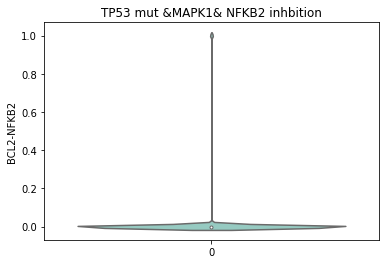

MAP2K2


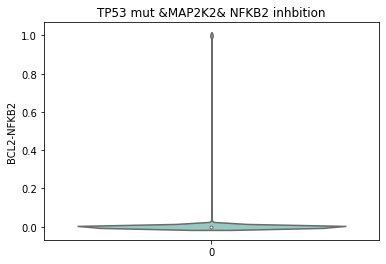

MEIS1


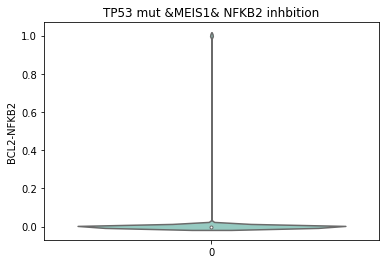

DNMT3A


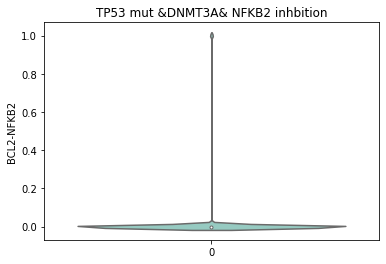

AKT1


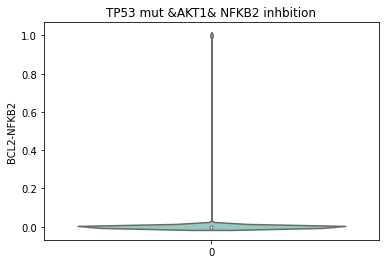

FBXW7


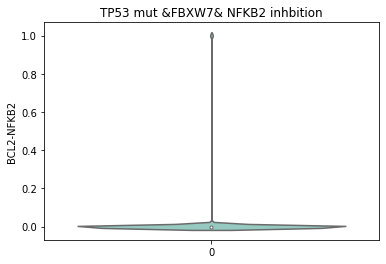

ETV6


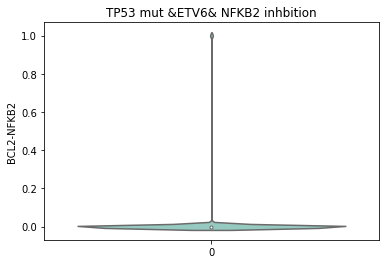

CEBPA


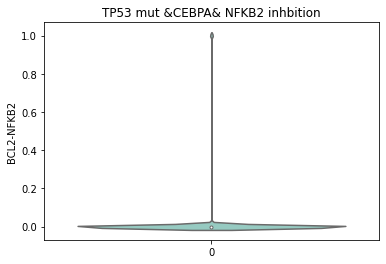

NPM1


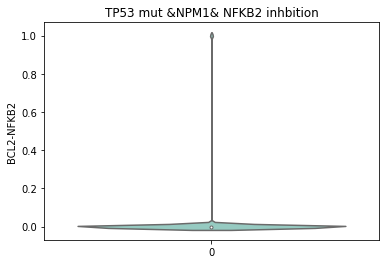

CDKN2A


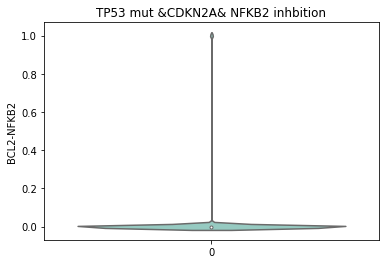

GSK3B


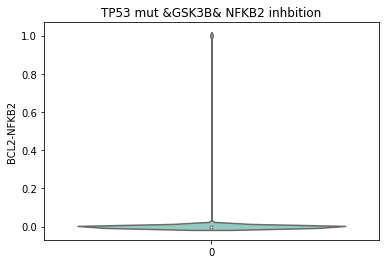

HOXA9


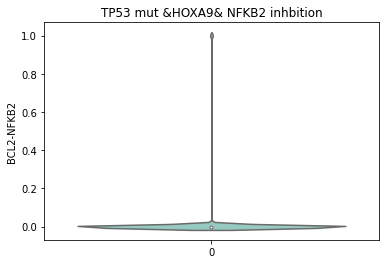

BCL2


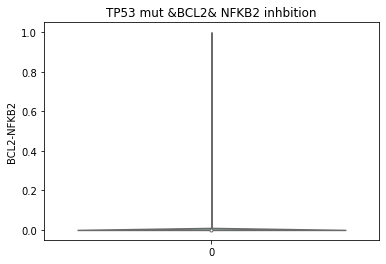

In [207]:
# random initial values
all_nodes = list(set(network['node1']) | set(network['node2']))
initial_values = [random.choice([True,False]) for i in range(0,len(all_nodes))]
print(initial_values)

# model initial
model_initial = KGBN.initial_model(all_nodes=all_nodes, initial_values=initial_values)

# run simulation
dic_nodes_upstream = KGBN.generate_dic_node_upstream(network)
for node in all_nodes:
    print(node)
    simulations = KGBN.update_models_multisteps_with_perterbation(model_initial,dic_nodes_upstream, runs = 200000, fliprop=0.01, onlist=["TP53"],offlist=["NFKB2",node])
    for node1 in simulations.keys():
        simulations[node1] = [int(x) for x in simulations[node1]]
    simulations = pd.DataFrame(simulations) 

    # plot the simulation results
    #plt.figure(figsize=(10,len(all_nodes)/3), dpi = 150)
    # heapmap without clustering
    #sns.heatmap(simulations.transpose(),cmap="YlGnBu", cbar = False)
    #plt.show()

    #plt.figure(figsize=(2,2), dpi = 150)
    # heapmap without clustering
    # violinplot
    sns.violinplot(data=(simulations['BCL2']-simulations['NFKB2']).values,palette="Set3")  
    plt.title("TP53 mut &" + node + "& NFKB2 inhbition")
    plt.ylabel("BCL2-NFKB2")
    #sns.boxplot(data=simulations['BCL2']-simulations['NFKB2'],palette="Set3")
    plt.show()

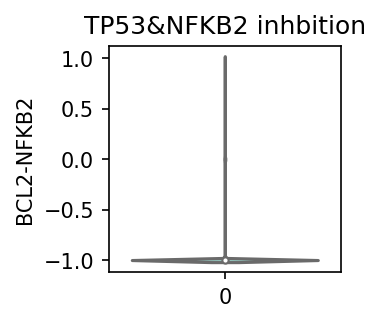

In [204]:
#boxplot
plt.figure(figsize=(2,2), dpi = 150)
# heapmap without clustering
# violinplot
sns.violinplot(data=(simulations['BCL2']-simulations['NFKB2']).values,palette="Set3")  
plt.title("TP53&NFKB2 inhbition")
plt.ylabel("BCL2-NFKB2")
#sns.boxplot(data=simulations['BCL2']-simulations['NFKB2'],palette="Set3")
plt.show()


In [193]:
all = pd.DataFrame()
delta = []
pre = count_state_frequency(simulations.iloc[0:10,:])
for i in range(0,14):
    cur = count_state_frequency(simulations.iloc[2**i*10:2**(i+1)*10,:])
    cur.columns = ["S"+str(i)]
    if i > 0:
        delta.append(cur.iloc[0,].values[0] - pre.iloc[0,].values[0])
    pre = cur
    all = pd.concat([all,cur],axis=1)


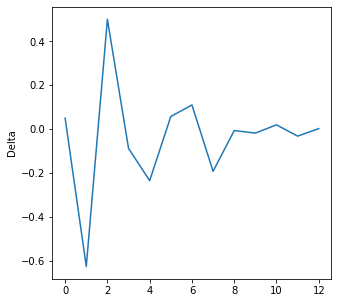

In [191]:
plt.figure(figsize=(5,5))
plt.ylabel("Delta")
plt.plot(delta)

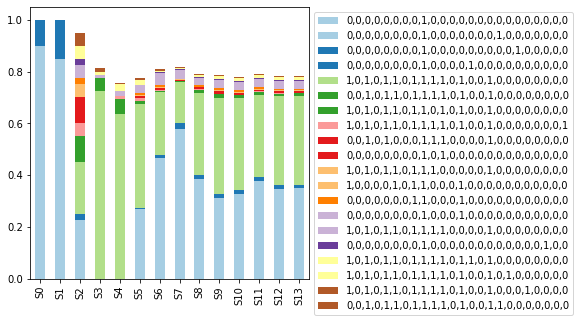

In [189]:
import pandas as pd

#static bar plot
all.head(20).transpose().plot(kind='bar', stacked=True, figsize=(5,5), legend=False, cmap='Paired')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()

<AxesSubplot:>

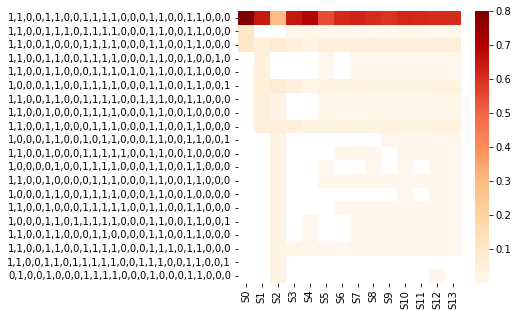

In [166]:
all.head(20)
plt.figure(figsize=(5,5))
sns.heatmap(all.head(20),cmap="OrRd", cbar = True)